# TF-IDF

In [1]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()
# !aws s3 ls s3://{bucket}/project/submissions/ --recursive

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
%pip install pyspark==3.4.0

# install seaborn
%pip install seaborn

%pip install wordcloud

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")




## Package Plan ##

  environment location: /opt/conda



Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install spark-nlp==5.5.0

In [4]:
from pyspark.sql import SparkSession
import sparknlp
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","32G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")\
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider")\
    .getOrCreate()

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/sagemaker-user/.ivy2/cache
The jars for the packages stored in: /home/sagemaker-user/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f40db406-d049-4c76-9089-cac90a288a77;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.go

3.4.0


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df_transformed = spark.read.parquet(f"s3a://{bucket}/project/pipelined_submissions/*.parquet", header=True).cache()

24/12/12 09:25:07 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [7]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

tokenizer= Tokenizer(inputCol="text", outputCol="tokens")
hashingTF = HashingTF(inputCol="tokens", outputCol="FeatureVectors")
idf = IDF(inputCol="FeatureVectors", outputCol="Features")

tokenized_data = tokenizer.transform(df_transformed)
hashed_data = hashingTF.transform(tokenized_data)
idf_model = idf.fit(hashed_data)
tfidf_data = idf_model.transform(hashed_data)

In [8]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf

names = ["trump", "biden", "hunter", "harris", "border", "israel", "war", "administration", "news"]
schema = StructType([StructField("tokens", ArrayType(StringType()))])

for i in names:
    df = spark.createDataFrame(([[[i]]]), schema).toDF("tokens")
    hashed_df = hashingTF.transform(df)
    featureVec = hashed_df.select('FeatureVectors').collect()
    ID = int(featureVec[0].FeatureVectors.indices[0])
    termExtractor = udf(lambda x: float(x[ID]), FloatType())
    tfidf_data = tfidf_data.withColumn(f'{i}_score', termExtractor(tfidf_data.Features))

In [9]:
tfidf_df = tfidf_data.toPandas()

24/12/12 09:25:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/12 09:25:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


In [10]:
border_df = tfidf_df.groupby(['subreddit', 'sentiment']).agg({'border_score': lambda x: x[x != 0].mean()}).unstack().reset_index()
border_df.to_csv("../../data/tables/border_table.csv")
border_df

subreddit border_score                    
sentiment                   negative   neutral  positive
0          Conservative     4.400743  4.282261  4.429996
1               Liberal     4.096076       NaN  4.096076
2           Libertarian     4.096076       NaN       NaN
3            Republican     4.804039  4.973806  4.232611
4             democrats     6.085598  4.096076  4.096076
5              politics     4.242364  4.247782  4.159093

In [11]:
israel_df = tfidf_df.groupby(['subreddit', 'sentiment']).agg({'israel_score': lambda x: x[x != 0].mean()}).unstack().reset_index()
israel_df.to_csv("../../data/tables/israel_table.csv")
israel_df

subreddit israel_score                    
sentiment                   negative   neutral  positive
0          Conservative     4.336109       NaN  4.173768
1               Liberal     5.266312       NaN  4.069423
2           Libertarian     5.634585       NaN       NaN
3            Republican     4.461657       NaN  4.069423
4             democrats     4.853890  4.069423  4.069423
5              politics     4.385980  8.138845  4.069424

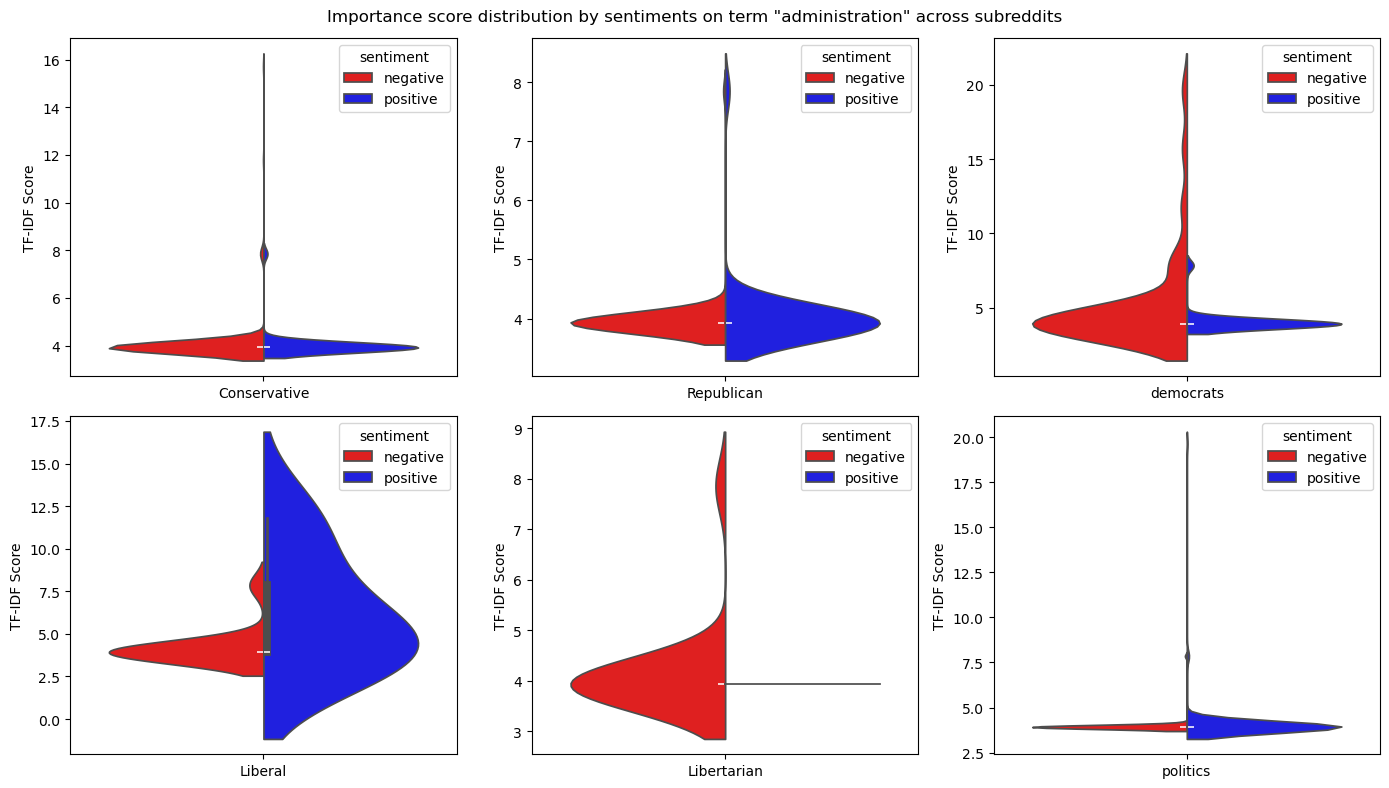

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

color_palette = ['red', 'blue']

# Loop through subreddits and corresponding axes
subreddits = ['Conservative', 'Republican', 'democrats', 'Liberal', 'Libertarian', 'politics']

for i, s in enumerate(subreddits):
    sub_df = tfidf_df[(tfidf_df["subreddit"] == s) & 
                      (tfidf_df["is_administration"] == 1) & 
                      (tfidf_df["administration_score"] != 0) &
                      (tfidf_df["sentiment"].isin(["positive","negative"]))]

    sns.violinplot(ax=axes[i], data=sub_df, x='subreddit', y='administration_score', hue='sentiment', split=True, palette=color_palette, hue_order=["negative", "positive"])
    
    # Add labels and title
    axes[i].set_xlabel(None)
    axes[i].set_ylabel('TF-IDF Score')

# Adjust layout for better spacing
plt.suptitle('Importance score distribution by sentiments on term "administration" across subreddits')
plt.tight_layout()
plt.savefig("../../website-source/plots/tf_idf.png", format="png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

In [13]:
# df_ml = tfidf_data \
#     .withColumn("is_hunter", F.when(F.col("text").rlike(r"(?i)hunter"), 1).otherwise(0)) \
#     .withColumn("is_border", F.when(F.col("text").rlike(r"(?i)border"), 1).otherwise(0)) \
#     .withColumn("is_war", F.when(F.col("text").rlike(r"(?i)war"), 1).otherwise(0)) \
#     .withColumn("is_israel", F.when(F.col("text").rlike(r"(?i)israel"), 1).otherwise(0)) \
#     .withColumn("is_harris", F.when(F.col("text").rlike(r"(?i)harris"), 1).otherwise(0)) \
#     .withColumn("is_administrationt", F.when(F.col("text").rlike(r"(?i)administration"), 1).otherwise(0)) \
#     .withColumn("is_indictment", F.when(F.col("text").rlike(r"(?i)indictment"), 1).otherwise(0)) \
#     .select('subreddit','author','id','text','num_comments','score','date','sentiment','is_biden','is_trump','trump_score', 'biden_score',
#              "is_hunter","is_border","is_war","is_israel","is_harris","is_indictment",'is_administrationt')
# pd_df = df_ml.toPandas()
# pd_df.to_csv("../../data/csv/df_ml.csv")